<h1>Sound Classification - part 1</h1>

As I have mentioned in Introduction I will use UrbanSound8K dataset. Let's start from short describtion of the dataset. It is very  important to understand the data that you are working with. Here is the dataset author's description:

<b>Dataset's author's description</b></br>
"This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper (https://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf). All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided.

'UrbanSound8k.csv'

This file contains meta-data information about every audio file in the dataset. This includes:

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music."

First I need to import required python's libraries. Then I will inspect our data.

In [1]:
import pandas as pd
pd.options.display.max_columns = 500
import librosa as lb
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
from scipy.stats import skew, kurtosis
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

Reading the metadata file into pandas dataframe.

In [2]:
df = pd.read_csv('UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
df.shape

(8732, 8)

8732 excerpts decribed in 8 columns. Let's take a look at first column.

In [4]:
df.slice_file_name.describe()

count                 8732
unique                8732
top       100032-3-0-0.wav
freq                     1
Name: slice_file_name, dtype: object

Every file has unique name. Files are in "WAV" format.

In [5]:
df.fsID.value_counts()

24347     100
180937     95
72259      73
203929     72
62837      66
         ... 
196065      1
196064      1
196062      1
196061      1
100032      1
Name: fsID, Length: 1297, dtype: int64

We can see that from one audio record (fsID) there was taken from 1 to 100 excerpts.

Next two columns include information about start time and end time of excerpt in source record. We can easily calculate the duration time of each excerpt. The dataset author's say that the audio duration is 4 s.

In [6]:
temp = df.end - df.start
temp.describe()

count    8732.000000
mean        3.607904
std         0.973570
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
dtype: float64

Most of excerpts lasts for exactly 4 s (more than 3/4 of all excerpts). But there are also shorter audios. The shortest one lasts only 54,545 ms. It is very meaningful aspect. We will need to take care for that.

In [7]:
df['salience'].value_counts()

1    5702
2    3030
Name: salience, dtype: int64

In 3030 excerpts the sound which has to be recognized is (subjectively) rated as the background sound. We can expect that signal to noise ratio (SNR) is very low. It is very significant and can have impact on the recognition preformance.

In [8]:
df['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

The excerpts occure in comparable numbers in different folds.</br>
Now let's check what are the relative numbers of excerpts of each classes in the dataset.

In [9]:
df['class'].value_counts()/len(df)

dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
engine_idling       0.114521
jackhammer          0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64

The percentage of 'gun_shot' and 'car_horn' are significantly less then for other classes.</br>
Let's check the excerpts sampling rate and channel numbers. We will add this information to our metadata dataframe.

In [10]:
# register the time to measure the code execution duration
start = time.time()

channel_count = []
sampling_rate = []
for i in range(len(df)):
    filename = 'fold' + str(df.iloc[i]['fold']) + '/' + df.iloc[i]['slice_file_name']
    y, sr = librosa.load(filename, sr=None, mono=False)
    
    temp = np.min(y.shape)
    
    # to handle the case were shape looks like (23425,) which can occure for 1 channel wav files
    # we need to overwrite 'temp' with value 1, we expect only mono or stereo audio files
    if temp > 2:
        temp = 1
    channel_count.append(temp)
    sampling_rate.append(sr)

df['channel_count'] = pd.Series(channel_count, index = df.index)
df['sampling_rate'] = pd.Series(sampling_rate, index = df.index)

print('Total time: ', time.time() - start)

Total time:  78.31209659576416


In [11]:
# let's save our modified df to file
with open('part1_df.pickle', 'wb') as f:
            pickle.dump(df, f)

# Loading saved df from file
# with open('part1_df.pickle', 'rb') as f:
#             df = pickle.load(f)

In [12]:
df['channel_count'].value_counts()

2    7993
1     739
Name: channel_count, dtype: int64

In [13]:
df['sampling_rate'].value_counts()

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: sampling_rate, dtype: int64

44100 Hz is the sampling rate that occures in most excerpts.

Let's take a look at first excerpt. (changing the <i>row_id</i> to other value you can snoop another excerpts) 

In [14]:
row_id = 0
df.iloc[row_id]

slice_file_name    100032-3-0-0.wav
fsID                         100032
start                           0.0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
channel_count                     2
sampling_rate                 44100
Name: 0, dtype: object

It was classiffied as 'dog_bark'. It occures in foreground of this audio. The audio duration is only 0,32 s. We will read the file and check the sampling rate using librosa library. Then we will also plot the signal in time domain using librosa.display.

In [15]:
# reading the file
file_path = 'fold' + str(df.iloc[row_id]['fold']) + '/' + df.iloc[row_id]['slice_file_name']
y, sr = librosa.load(file_path, sr=None, mono=False)
print('y',y.shape,'sr',sr)

y (2, 14004) sr 44100


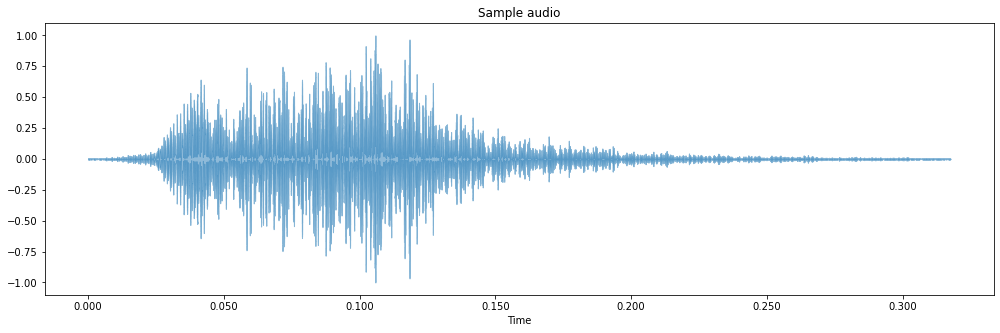

In [16]:
#plot audio
plt.figure(figsize=(17,5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title('Sample audio');

Let's listen to this audio.

In [17]:
ipd.Audio(file_path)

In this part, to get our baseline described in mentioned paper, we will extract features from mono audio files with sampling rate 22050 Hz. Audio will be converted to mono and resampled (if needed) during reading audio from file. We will extract Mel-Frequency Cepstral Coefficients (MFCC) from the audio slices using the Librosa library. We will extract the features on a per-frame basis using a window size of 23.2 ms and 50% frame overlap. We will compute 40 Mel bands between 0 and 22050 Hz and keep the first 25 MFCC coefficients (we do not apply any pre-emphasis nor liftering). The per-frame values for each coefficient are agregated across time using the following summary statistics: minimum, maximum, median, mean, variance, skewness, kurtosis and the mean and variance of the first and second derivatives, resulting in a feature vector of dimension 225 per excerpt.</br>
We will score our machine learning (ML) models with cross validation using predefined 10 folds.

<b>Why using predefined 10 folds?</b></br>
What is very important and what you can find in dataset authors paper, from one source audio file many excerpts were extracted. They also overlap one on each other. Look at 'start' and 'end' columns of different rows:

In [18]:
df.loc[df['fsID']==180937]

,slice_file_name,fsID,start,end,salience,fold,classID,class,channel_count,sampling_rate
4299,180937-4-0-11.wav,180937,5.500000,9.500000,2,9,4,drilling,2,96000
4300,180937-4-0-13.wav,180937,6.500000,10.500000,2,9,4,drilling,2,96000
4301,180937-4-0-14.wav,180937,7.000000,11.000000,2,9,4,drilling,2,96000
4302,180937-4-0-19.wav,180937,9.500000,13.500000,2,9,4,drilling,2,96000
4303,180937-4-0-20.wav,180937,10.000000,14.000000,2,9,4,drilling,2,96000
...,...,...,...,...,...,...,...,...,...,...
4389,180937-7-4-5.wav,180937,465.703523,469.703523,2,1,7,jackhammer,2,96000
4390,180937-7-4-6.wav,180937,466.203523,470.203523,2,1,7,jackhammer,2,96000
4391,180937-7-4-7.wav,180937,466.703523,470.703523,2,1,7,jackhammer,2,96000
4392,180937-7-4-8.wav,180937,467.203523,471.203523,2,1,7,jackhammer,2,96000


We do not want to use the same data for training and for validation or testing. The good information is that dataset's authors took care for it and all excerpts that were extracted from the same source audio are placed in the same fold.

In [19]:
df.loc[(df['fsID']==180937) & (df['classID']==4)]['fold'].value_counts()

9    16
Name: fold, dtype: int64

In [20]:
df.loc[(df['fsID']==180937) & (df['classID']==7)]['fold'].value_counts()

1    79
Name: fold, dtype: int64

So, using the predefined 10 fold help us to avoid unwanted 'data leakage'. If we split data to training and testing sets randomly, we could with high propability use the same information for training and testing our models.

Let's start to extract our mfcc features. We will use librosa.feature.mfcc function.

In [21]:
def get_mfcc_features_from_signal(y, sr):
    """y must be one channel signal resampled to 22050 Hz if needed"""
    # parameters according to description from Salomon, Jacoby and Bello to extract mfcc's
    # compute 40 mel bands
    MEL_BANDS = 40
    # frame size of 23,2 ms, because sampling rate is 22050 Hz -> frame size have to be 512 samples
    FRAME_SIZE = 512 # we use it as number of fft point because from n samples we get n points fft
    # 50% frame overlap
    HOP_SIZE = 256
    
    mfccs = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=MEL_BANDS, n_fft=FRAME_SIZE, hop_length=HOP_SIZE) #we get 2D table, axis x is 'time like', and on axis y we have 40 coefs
    
    #make dictonary with features to keep general convention
    features = {}
    
    for i in range(25): # they calculated 40 mfccs but used only 25 first
        mfccs_row = mfccs[i,:]
        delta = [0] #1st element in derivative will be equal 0
        delta.extend([mfccs_row[j+1] - mfccs_row[j] for j in range(len(mfccs_row) - 1)])
        delta2 = [0] #1st element in derivative will be equal 0
        delta2.extend([delta[j+1] - delta[j] for j in range(len(delta) - 1)])
        
        prefixes = ['', 'delta_', 'delta2_']
        data = [mfccs_row, delta, delta2]
        
        for k in range(3):
            features[prefixes[k]+'mfcc_'+str(i+1)+'_mean'] = np.mean(data[k])            
            features[prefixes[k]+'mfcc_'+str(i+1)+'_var'] = np.var(data[k])
            if k > 0: continue
            features[prefixes[k]+'mfcc_'+str(i+1)+'_median'] = np.median(data[k])
            features[prefixes[k]+'mfcc_'+str(i+1)+'_min'] = np.min(data[k])
            features[prefixes[k]+'mfcc_'+str(i+1)+'_max'] = np.max(data[k])
            features[prefixes[k]+'mfcc_'+str(i+1)+'_skew'] = skew(data[k])
            features[prefixes[k]+'mfcc_'+str(i+1)+'_kurtosis'] = kurtosis(data[k])
    return features

# get_mfcc_features_from_signal(y, sr)

In [22]:
# open the same file but converted to mono and 22050 Hz
y, sr = librosa.load(file_path, sr=22050, mono=True)

# get mfccs
get_mfcc_features_from_signal(y, sr)

{'mfcc_1_mean': -374.56924,
 'mfcc_1_var': 19669.385,
 'mfcc_1_median': -383.6637,
 'mfcc_1_min': -600.79956,
 'mfcc_1_max': -170.02863,
 'mfcc_1_skew': -0.041771455101594294,
 'mfcc_1_kurtosis': -1.4432844085601095,
 'delta_mfcc_1_mean': 0.5803070068359375,
 'delta_mfcc_1_var': 1721.2787657589652,
 'delta2_mfcc_1_mean': -0.7981087820870536,
 'delta2_mfcc_1_var': 558.2864137121728,
 'mfcc_2_mean': 61.10306,
 'mfcc_2_var': 602.5244,
 'mfcc_2_median': 60.618786,
 'mfcc_2_min': 21.466846,
 'mfcc_2_max': 129.51373,
 'mfcc_2_skew': 0.5383539741579354,
 'mfcc_2_kurtosis': 0.06986983237203193,
 'delta_mfcc_2_mean': -0.4032679966517857,
 'delta_mfcc_2_var': 232.25984586595055,
 'delta2_mfcc_2_mean': -0.0767991202218192,
 'delta2_mfcc_2_var': 622.8357671877108,
 'mfcc_3_mean': -117.44283,
 'mfcc_3_var': 647.0488,
 'mfcc_3_median': -121.619415,
 'mfcc_3_min': -151.21622,
 'mfcc_3_max': -33.413254,
 'mfcc_3_skew': 1.3567545840610404,
 'mfcc_3_kurtosis': 2.190004430135498,
 'delta_mfcc_3_mean': -1

Ok, we got a dictionary with features names as keys, and features values as values. Later we will extract different features in that form.</br>
Now we need a function that will extract features from every excerpt in our dataset and build a pandas DataFrame with features, pandas Sierie with class labels. We also want to keep indexes from metadata file.

In [23]:
def get_mfccs_features(data_frame):
    st = time.time()
    
    classes = []
    
    for i in range(len(data_frame)):
        # getting the file name from dataset metadata
        file_path = 'fold' + str(data_frame.iloc[i]['fold']) + '/' + data_frame.iloc[i]['slice_file_name']
        
        # Salomon, Hacoby and Bello used 22050 Hz sampling rate
        # geting audio as numpy.ndarray, during file reading the audio is converted to mono and resampled to 22050 if needed
        y, sr = lb.load(file_path, mono=True, sr=22050)
        
        # for the short audio we will append zeros to get 4 seconds audio, this way we will allways get the same number
        # of samples for futher computing
        y = np.concatenate((y, np.zeros(4*sr)))
        y = y[0:4*sr]
        
        #mfcc_features
        features = get_mfcc_features_from_signal(y, sr)
        
        temp = pd.DataFrame(data=features, index=[data_frame.index[i]]) #we need to keep original index value from meta-data file
        
        if i==0:
            X = temp
        else:
            X = pd.concat([X, temp])
        if i%200==0:
            print('Progress: ',i/len(data_frame),'  Elapsed: ', time.time()-st)
            
        classes.append(data_frame.iloc[i]['class'])
        
    Y = pd.Series(classes, name='class', index=X.index)
    return X, Y

In [24]:
# generating X and Y using 'get_mfcc_features()' function - it takes some time
# start = time.time()
# X, Y = get_mfccs_features(df)
# print(time.time()-start)

# let's save our X and Y to files
# with open('part1_X.pickle', 'wb') as f:
#             pickle.dump(X, f)
# with open('part1_Y.pickle', 'wb') as f:
#             pickle.dump(Y, f)

# Loading saved X and Y from files
with open('part1_X.pickle', 'rb') as f:
            X = pickle.load(f)
with open('part1_Y.pickle', 'rb') as f:
            Y = pickle.load(f)

Let's check what is the shape of our features

In [25]:
X.shape

(8732, 275)

We have 8732 rows - one of every excerpt in our dataset. We have 275 features (columns).</br>
To keep ten folds division during models cross validating, we need to write custom function:

In [26]:
def my_cross_val_using_10_folds(clf, X, data):
    """clf is our classifier
    X are our features
    we use 'data' to get class labels and to select indexes related to individual folders"""
    sc = []
    if len(X.index) != len(data.index):
        print("Indexes of X and data are not the same length!!!")
        return sc
    if (X.index != data.index).any():
        print("Indexes of X and data are not equal!!!")
        return sc
    for i in range(1,11):
        X_train = X.loc[data['fold']!=i]
        Y_train = data.loc[data['fold']!=i]['class']
        X_test = X.loc[data['fold']==i]
        Y_test = data.loc[data['fold']==i]['class']
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        temp = np.sum(Y_pred==Y_test)/len(Y_test)
        sc.append(temp)
    return sc

Most of ML models perform better with scaled features. We will get scaled X dataframe and we will compare results using both scaled and unscaled features.

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform() returns numpy.ndarray, if we want to keep indexes and column names, we do it like this
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

We will get accuracy metrics for 5 ML models and register it in dictionary

In [28]:
score_table_unscaled = {}
score_table_scaled = {}

<h2>Decision Tree</h2></br>
Model with default parameters.

In [29]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=44)
scores = my_cross_val_using_10_folds(dt_clf, X, df)
score_table_unscaled['Decision Tree']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.483864795510441


In [30]:
scores = my_cross_val_using_10_folds(dt_clf, X_scaled, df)
score_table_scaled['Decision Tree']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.483864795510441


<h2> K-Nearest Neighbours </h2></br>
Model set for 5 nearest neighbours.

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
scores = my_cross_val_using_10_folds(knn_clf, X, df)
score_table_unscaled['KNN']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.5067729410494388


In [32]:
scores = my_cross_val_using_10_folds(knn_clf, X_scaled, df)
score_table_scaled['KNN']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.541045354282388


<h2> Random Forest </h2></br>
Model set for 500 trees.

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=44, n_estimators=500)
scores = my_cross_val_using_10_folds(rf_clf, X, df)
score_table_unscaled['Random Forest']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.688119833451778


In [34]:
scores = my_cross_val_using_10_folds(rf_clf, X_scaled, df)
score_table_scaled['Random Forest']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.6881544640903499


<h2> Support Vector Machines </h2>
Model with 'rbf' kernel which is default.

In [35]:
from sklearn.svm import SVC
svc_clf = SVC(random_state=44)
scores = my_cross_val_using_10_folds(svc_clf, X, df)
score_table_unscaled['SVM']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.3446480394159641


In [36]:
scores = my_cross_val_using_10_folds(svc_clf, X_scaled, df)
score_table_scaled['SVM']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.6918016772355459


<h2>Zero R</h2></br>
Model used with strategy 'most_frequent'. In fact it is used only as baseline to check if other models are able to learn and if they add any value.

In [37]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
scores = my_cross_val_using_10_folds(dummy_clf, X, df)
score_table_unscaled['Zero R']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.10202262335001408


In [38]:
scores = my_cross_val_using_10_folds(dummy_clf, X_scaled, df)
score_table_scaled['Zero R']=np.mean(scores)
print('Average score: ', np.mean(scores))

Average score:  0.10202262335001408


In [39]:
score_table = pd.concat([pd.Series(score_table_unscaled, name='base_X_unscaled'),
                         pd.Series(score_table_scaled, name='base_X_scaled')], axis=1)
score_table['max'] = score_table.max(axis=1)
score_table.sort_values(by='max', ascending=False)

,base_X_unscaled,base_X_scaled,max
SVM,0.344648,0.691802,0.691802
Random Forest,0.688120,0.688154,0.688154
KNN,0.506773,0.541045,0.541045
Decision Tree,0.483865,0.483865,0.483865
Zero R,0.102023,0.102023,0.102023


We have the 5 models that were tried by UrbanSound8K authors and we get comparable results (column 'max') as they got for 4 s excerpts.</br>

At the end of this part let's check what if we splited our dataset randomly for cross validation.

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_clf, X, Y, cv=10, n_jobs=-1, scoring='accuracy')
print("Decision Tree scores")
print("Using predefined 10 folds: ", score_table_unscaled['Decision Tree'])
print("Randomly splited dataset: ", np.mean(scores))

Decision Tree scores
Using predefined 10 folds:  0.483864795510441
Randomly splited dataset:  0.49472937161370484


In [41]:
scores = cross_val_score(knn_clf, X_scaled, Y, cv=10, n_jobs=-1, scoring='accuracy')
print("KNN scores")
print("Using predefined 10 folds: ", score_table_scaled['KNN'])
print("Randomly splited dataset: ", np.mean(scores))

KNN scores
Using predefined 10 folds:  0.541045354282388
Randomly splited dataset:  0.5613829321548305


In [42]:
scores = cross_val_score(rf_clf, X_scaled, Y, cv=10, n_jobs=-1, scoring='accuracy')
print("Random Forest scores")
print("Using predefined 10 folds: ", score_table_scaled['Random Forest'])
print("Randomly splited dataset: ", np.mean(scores))

Random Forest scores
Using predefined 10 folds:  0.6881544640903499
Randomly splited dataset:  0.6994955452279287


In [43]:
scores = cross_val_score(svc_clf, X_scaled, Y, cv=10, n_jobs=-1, scoring='accuracy')
print("SVM scores")
print("Using predefined 10 folds: ", score_table_scaled['SVM'])
print("Randomly splited dataset: ", np.mean(scores))

SVM scores
Using predefined 10 folds:  0.6918016772355459
Randomly splited dataset:  0.7127733610134704


In [44]:
scores = cross_val_score(dummy_clf, X, Y, cv=10, n_jobs=-1, scoring='accuracy')
print("Zero R scores")
print("Using predefined 10 folds: ", score_table_unscaled['Zero R'])
print("Randomly splited dataset: ", np.mean(scores))

Zero R scores
Using predefined 10 folds:  0.10202262335001408
Randomly splited dataset:  0.11452132497686769


Obviously we got better results if we do not respect predefined 10 folds but we know that it is not the power of our ML models, it's a result of faulty data treatment.

<h3>Assumptions</h3></br>
1. We have base/reference models and their scores expressed by accuracy metric.</br>
2. We know that, in case of this dataset, we need to respect predefined 10 folds to avoid presenting to ML models test data during training process.